# Librerias

In [1]:
import fastai.collab as fc
import fastai.tabular.all as ft
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Indice
- [Primer intento](#intento1)
- [Mejorando el modelo](#improving)
- [Segundo intento](#intento2)
- [Separando columnas](#columnas)
- [Evaluando el nuevo modelo](#newmodel)
- [Un modelo que lo tiene todo](#newmodel_all)
- [Conclusión](#conc)

In [8]:
!ls

archive  data  faces  images  models  mydata  recommendation_system.ipynb


In [2]:
animes = pd.read_csv('/notebooks/storage/mydata/animes.csv')
animes.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310
uid,28891,23273,34599,5114,31758,37510,199,38000,35247,2904,...,10350,1699,1293,150,4177,32979,123,1281,450,87
title,Haikyuu!! Second Season,Shigatsu wa Kimi no Uso,Made in Abyss,Fullmetal Alchemist: Brotherhood,Kizumonogatari III: Reiketsu-hen,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Kimetsu no Yaiba,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,...,Hakuouki Sekkaroku,Romeo x Juliet,Urusei Yatsura,Blood+,Bounen no Xamdou,Flip Flappers,Fushigi Yuugi,Gakkou no Kaidan,InuYasha Movie 2: Kagami no Naka no Mugenjo,Mobile Suit Gundam: Char's Counterattack


In [3]:
users = pd.read_csv('/notebooks/storage/mydata/profiles.csv')
users.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,81717,81718,81719,81720,81721,81722,81723,81724,81725,81726
profile,DesolatePsyche,baekbeans,skrn,edgewalker00,aManOfCulture99,eneri,Waffle_Empress,NIGGER_BONER,jchang,shadowsplat,...,suzumehime,HajisSoul,samdineen20,bri_bri101,anjel,lovelessxd,Shattered_Angel,FluffyWalrus,camco,nyja-chan
gender,Male,Female,NaN,Male,Male,NaN,NaN,Male,Male,NaN,...,Female,Male,Female,Female,Female,Female,Female,Male,Female,Female


In [4]:
ratings = pd.read_csv('/notebooks/storage/mydata/reviews.csv', low_memory = True)
ratings.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,192102,192103,192104,192105,192106,192107,192108,192109,192110,192111
uid,255938,259117,253664,8254,291149,10046,247454,140903,23791,25115,...,223847,224292,181811,129039,279416,240067,285777,286904,287903,299323
profile,DesolatePsyche,baekbeans,skrn,edgewalker00,aManOfCulture99,eneri,Waffle_Empress,NIGGER_BONER,jchang,shadowsplat,...,Emil5634,BlazingWaters,Fear_the_Reefer,appleshampoo,Lordapollo,Unicorn819,ShizzoSVH,AlluMan96,AgentK300,Scarlet012


In [10]:
animes.columns

Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link'],
      dtype='object')

In [11]:
users.columns

Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')

<a id="intento1"><strong><h1>Primer intento: SOLO usando los ratings de los usuarios</h1></strong></a>

In [12]:
ratings.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

In [22]:
ratings = ratings[['uid', 'anime_uid', 'score']]

In [23]:
ratings.head()

,uid,anime_uid,score
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


In [24]:
dls = fc.CollabDataLoaders.from_df(ratings, user_name = 'uid', item_name = 'anime_uid', rating_name = 'score', bs=128)

In [5]:
def flat_l1(yp, y): 
    return F.l1_loss(yp.view(-1), y.view(-1))

In [26]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, metrics=flat_l1)

In [27]:
learn.model
# u_weight: vector de usuarios
# i_weight: vector de animes 
# el número 50 en el vector viene del mismo colla_learner (lo puedes modificar)

EmbeddingDotBias(
  (u_weight): Embedding(114153, 50)
  (i_weight): Embedding(7722, 50)
  (u_bias): Embedding(114153, 1)
  (i_bias): Embedding(7722, 1)
)

In [29]:
learn.summary()

EmbeddingDotBias (Input shape: ['128 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            128 x 50             5,707,650  True      
________________________________________________________________
Embedding            128 x 50             386,100    True      
________________________________________________________________
Embedding            128 x 1              114,153    True      
________________________________________________________________
Embedding            128 x 1              7,722      True      
________________________________________________________________

Total params: 6,215,625
Total trainable params: 6,215,625
Total non-trainable params: 0

Optimizer used: <function ranger at 0x7f4746582e50>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

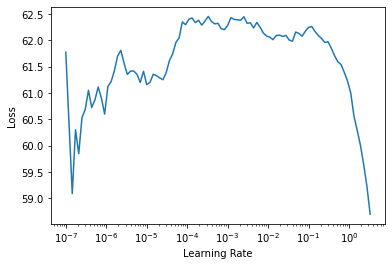

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,16.992338,16.166050,3.183861,00:12
1,7.017893,11.902308,2.608928,00:12
2,3.316580,11.402295,2.560741,00:12
3,2.910199,10.656550,2.442939,00:12
4,2.677184,10.136228,2.341321,00:12
5,2.483772,9.940720,2.297748,00:12
6,2.334622,9.768309,2.278651,00:12
7,2.291236,9.652760,2.251185,00:12
8,2.265074,9.578252,2.238924,00:12
9,2.326563,9.533548,2.231110,00:12


Básicamente nuestro modelo hasta ahora se equivoca en promedio un 1.8, tipo, tú ibas a dar la calificación de 5 y el modelo predice un 6.8.

<a id="improving"><strong><h1>Mejorando el modelo</h1></strong></a>

In [32]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 32, metrics=flat_l1)

In [33]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,17.047792,16.205851,3.195513,00:10
1,7.113659,11.320663,2.525270,00:10
2,3.304504,10.898797,2.493097,00:10
3,2.604981,10.203039,2.382646,00:10
4,2.343957,9.695484,2.279660,00:10
5,2.110753,9.484293,2.231323,00:10
6,1.947385,9.327130,2.209932,00:10
7,1.979636,9.228442,2.190621,00:10
8,1.826484,9.093459,2.163163,00:10
9,1.861269,9.096714,2.162258,00:10


In [34]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 4, metrics=flat_l1)

In [35]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,19.086966,18.143942,3.515608,00:09
1,8.347507,10.572177,2.427779,00:09
2,4.754016,8.727262,2.157624,00:09
3,2.990532,7.989791,2.051735,00:09
4,2.146818,7.603972,1.991534,00:09
5,1.834746,7.321267,1.909319,00:09
6,1.587840,7.202202,1.907813,00:09
7,1.500084,7.091961,1.869445,00:09
8,1.336291,7.029622,1.862495,00:09
9,1.266957,6.963642,1.845093,00:09


**Ahora usamos una red neuronal y embeddings para predecir los scores**

In [36]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 16, 'anime_uid': 16}, metrics=flat_l1)
# aquí, el embedding del anime y del usuario no tiene que ser del mismo tamaño necesariamente

In [37]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(114153, 16)
    (1): Embedding(7722, 16)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=32, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [38]:
learn.summary()

EmbeddingNN (Input shape: ['128 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            128 x 16             1,826,448  True      
________________________________________________________________
Embedding            128 x 16             123,552    True      
________________________________________________________________
Dropout              128 x 32             0          False     
________________________________________________________________
BatchNorm1d          128 x 32             64         True      
________________________________________________________________
Linear               128 x 50             1,600      True      
________________________________________________________________
ReLU                 128 x 50             0          False     
________________________________________________________________
Linear               128 x 1              51         True      
___________________________________________________________

In [39]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,3.370636,3.247148,1.396185,00:11
1,1.418539,2.784734,1.209292,00:11
2,0.919571,2.630530,1.152667,00:12
3,0.772118,2.584629,1.134441,00:12
4,0.583331,2.546520,1.104645,00:13
5,0.517081,2.527133,1.099811,00:15
6,0.482318,2.533254,1.090999,00:12
7,0.470444,2.512447,1.075809,00:14
8,0.445987,2.531115,1.067248,00:12
9,0.474148,2.517100,1.054031,00:12


In [40]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 32, 'anime_uid': 32}, layers = [1024, 512], metrics=flat_l1)
# hacemos el modelo más profundo

In [41]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,3.310527,3.305095,1.372719,00:13
1,1.670862,2.754833,1.172801,00:12
2,0.867559,2.696796,1.114985,00:12
3,0.672564,2.674608,1.122099,00:12
4,0.556546,2.690375,1.075964,00:12
5,0.519311,2.973881,1.169870,00:12
6,0.560468,3.119360,1.176510,00:12
7,0.618673,2.871677,1.145784,00:12
8,0.592854,3.263130,1.101028,00:12
9,0.583192,5.222058,1.146698,00:12


<a id="intento2"><strong><h1>Segundo intento: AÑADIENDO más columnas</h1></strong></a>

Pero primero, un preprocesamiento 

## Ratings

In [6]:
ratings.head(1)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n \n \n \n \n more pics \n \n \n \n \n \n Overall \n 8 \n \n \n Story \n 8 \n \n \n Animation \n 8 \n \n \n Sound \n 10 \n \n \n Character \n 9 \n \n \n Enjoyment \n 8 \n \n \n \n\n \n First things firs...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8', 'Sound': '10', 'Character': '9', 'Enjoyment': '8'}",https://myanimelist.net/reviews.php?id=255938


In [7]:
# Actualizamos las columnas de para trabajo con ratings
my_ratings = ratings[["uid", "anime_uid", "score"]]

<AxesSubplot:>

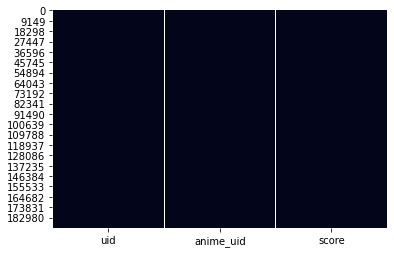

In [8]:
# ESTADO DE LOS DATOS
sns.heatmap(my_ratings.isnull(), cbar=False)

In [9]:
#Revisar el total de registros faltantes 
my_ratings.isna().sum()

uid          0
anime_uid    0
score        0
dtype: int64

In [10]:
#my_ratings.head(1)
my_ratings.loc[(my_ratings["anime_uid"] == 34096) & (my_ratings.uid == 255938)]

,uid,anime_uid,score
0,255938,34096,8
60897,255938,34096,8


In [11]:
my_ratings.shape

(192112, 3)

In [12]:
len(my_ratings.uid.unique())

130519

In [13]:
set(my_ratings.duplicated())

{False, True}

**Tenemos registros duplicados, procedemos a eliminarlos**

In [14]:
my_ratings = my_ratings.drop_duplicates()

In [15]:
set(my_ratings.duplicated())

{False}

## Animes

In [16]:
animes.head(1)
#animes.loc[(animes.uid == 34096)]

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead. \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but also come up with new attacks that would strengthen them. Moreover, Hinata and Kageyama attempt to d...","['Comedy', 'Sports', 'Drama', 'School', 'Shounen']","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/76662.jpg,https://myanimelist.net/anime/28891/Haikyuu_Second_Season


In [17]:
# Actualizamos las columnas de trabajo para animes
my_animes = animes[["uid", "title", "genre", "episodes", "popularity", "ranked", "score"]]

<AxesSubplot:>

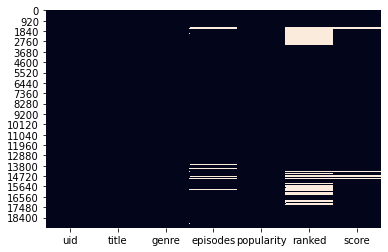

In [18]:
# ESTADO DE LOS DATOS
sns.heatmap(my_animes.isnull(), cbar=False)

In [19]:
#Revisar el total de registros faltantes 
my_animes.isna().sum()

uid              0
title            0
genre            0
episodes       706
popularity       0
ranked        3212
score          579
dtype: int64

In [20]:
my_animes.loc[(my_animes.uid == 34096)]

,uid,title,genre,episodes,popularity,ranked,score
11,34096,Gintama.,"['Action', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Shounen']",12.0,800,15.0,8.94
3088,34096,Gintama.,"['Action', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Shounen']",12.0,800,15.0,8.94


In [21]:
set(my_animes.duplicated())

{False, True}

**Podemos observar que hay registros duplicados en los animes**

In [22]:
my_animes.shape

(19311, 7)

In [23]:
len(my_animes.uid.unique())

16216

**Eliminamos los registros duplicados**

In [24]:
my_animes = my_animes.drop_duplicates()

In [25]:
set(my_animes.duplicated())

{False}

## Users

In [26]:
users.head(1)

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",https://myanimelist.net/profile/DesolatePsyche


In [27]:
my_animes.loc[(my_animes.uid == 18245)]

,uid,title,genre,episodes,popularity,ranked,score
898,18245,White Album 2,"['Drama', 'Music', 'Romance', 'Slice of Life']",13.0,697,925.0,7.8


In [28]:
my_users = users[["profile","gender", "favorites_anime"]]

<AxesSubplot:>

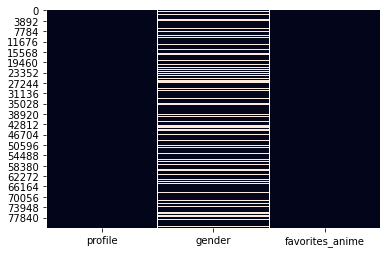

In [29]:
# ESTADO DE LOS DATOS
sns.heatmap(my_users.isnull(), cbar=False)

In [30]:
#Revisar el total de registros faltantes 
my_users.isna().sum()

profile                0
gender             27871
favorites_anime        0
dtype: int64

In [31]:
set(my_users.duplicated())

{False, True}

**Nuevamente tenemos registros faltantes, los eliminamos**

In [32]:
my_users = my_users.drop_duplicates()

In [33]:
set(my_users.duplicated())

{False}

<a id="columnas"><strong><h1>Ampliando columnas</h1></strong></a>
> "Separa la columna "género" en columnas de True/False (Comedia, Shonen, etc.)"

_anime_

In [34]:
my_animes.head(1)

,uid,title,genre,episodes,popularity,ranked,score
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']",25.0,141,25.0,8.82


In [35]:
all_genres = my_animes.genre
all_genres.head(1)

0    ['Comedy', 'Sports', 'Drama', 'School', 'Shounen']
Name: genre, dtype: object

In [36]:
my_genres = []
for i in all_genres.values:
    tmp = i.lstrip("[").rstrip("]").split(",")
    for element in tmp:
        element = element.strip()
        # if element in my_genres == True: pass else: my_genres.append(element) # me repite generos 
        if element not in my_genres: 
            my_genres.append(element)

In [37]:
my_genres

["'Comedy'",
 "'Sports'",
 "'Drama'",
 "'School'",
 "'Shounen'",
 "'Music'",
 "'Romance'",
 "'Sci-Fi'",
 "'Adventure'",
 "'Mystery'",
 "'Fantasy'",
 "'Action'",
 "'Military'",
 "'Magic'",
 "'Supernatural'",
 "'Vampire'",
 "'Slice of Life'",
 "'Demons'",
 "'Historical'",
 "'Super Power'",
 "'Mecha'",
 "'Parody'",
 "'Samurai'",
 "'Seinen'",
 "'Police'",
 "'Psychological'",
 "'Josei'",
 "'Space'",
 "'Kids'",
 "'Shoujo Ai'",
 "'Ecchi'",
 "'Shoujo'",
 "'Horror'",
 "'Shounen Ai'",
 "'Cars'",
 "'Martial Arts'",
 "'Game'",
 "'Thriller'",
 "'Dementia'",
 "'Harem'",
 '',
 "'Hentai'",
 "'Yaoi'",
 "'Yuri'"]

Tenemos un genero igual a '' lo cual no tiene sentido, lo eliminamos.

In [38]:
value_to_delete = my_genres[40]
my_genres.remove(value_to_delete)

In [39]:
my_genres

["'Comedy'",
 "'Sports'",
 "'Drama'",
 "'School'",
 "'Shounen'",
 "'Music'",
 "'Romance'",
 "'Sci-Fi'",
 "'Adventure'",
 "'Mystery'",
 "'Fantasy'",
 "'Action'",
 "'Military'",
 "'Magic'",
 "'Supernatural'",
 "'Vampire'",
 "'Slice of Life'",
 "'Demons'",
 "'Historical'",
 "'Super Power'",
 "'Mecha'",
 "'Parody'",
 "'Samurai'",
 "'Seinen'",
 "'Police'",
 "'Psychological'",
 "'Josei'",
 "'Space'",
 "'Kids'",
 "'Shoujo Ai'",
 "'Ecchi'",
 "'Shoujo'",
 "'Horror'",
 "'Shounen Ai'",
 "'Cars'",
 "'Martial Arts'",
 "'Game'",
 "'Thriller'",
 "'Dementia'",
 "'Harem'",
 "'Hentai'",
 "'Yaoi'",
 "'Yuri'"]

**Hasta aquí ya tenemos todos los tipos de generos que hay**
> Ahora el problema a resolver es añadir las columnas y marcar true o false 

In [40]:
my_animes.head()

,uid,title,genre,episodes,popularity,ranked,score
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']",25.0,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shounen']",22.0,28,24.0,8.83
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'Fantasy']",13.0,98,23.0,8.83
3,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic', 'Fantasy', 'Shounen']",64.0,4,1.0,9.23
4,31758,Kizumonogatari III: Reiketsu-hen,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,502,22.0,8.83


In [41]:
# generamos un diccionario de generos
genres_columns = {genero: False for genero in my_genres}
#genres_columns

In [42]:
# Creamos un dataframe del tamaño de my_animes, que correspondera a los generos
df_genres_columns = pd.DataFrame(genres_columns, index = my_animes.index)

In [43]:
df_genres_columns.head(1)

,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery',...,'Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
# Reutilizamos el código anterior pero ahora para detectar el tipo de genero en cada anime
for i in range(len(all_genres.values)):
    tmp = all_genres.values[i].lstrip("[").rstrip("]").split(",")
    for element in tmp:
        element = element.strip()
        if element in my_genres:
            df_genres_columns.loc[i,[element]] = True
      
               
# No es lo más optimo pero funcina

In [45]:
df_genres_columns.head(5)

,'Comedy','Sports','Drama','School','Shounen','Music','Romance','Sci-Fi','Adventure','Mystery',...,'Shounen Ai','Cars','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
0,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,True,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [46]:
my_animes.head(5)

,uid,title,genre,episodes,popularity,ranked,score
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']",25.0,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shounen']",22.0,28,24.0,8.83
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'Fantasy']",13.0,98,23.0,8.83
3,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic', 'Fantasy', 'Shounen']",64.0,4,1.0,9.23
4,31758,Kizumonogatari III: Reiketsu-hen,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,502,22.0,8.83


<AxesSubplot:>

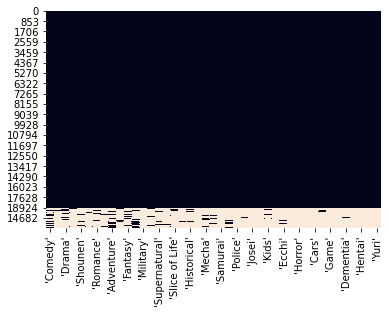

In [47]:
sns.heatmap(df_genres_columns.isnull(), cbar=False)

Los datos faltantes corresponden a ese genero que detecto el código que solo corresponde a un espacio en blanco, mismo que eliminamos más arriba.

In [48]:
# Procedemos a unir los dataframes
my_animes_g = my_animes.join(df_genres_columns)
my_animes_g.head(1).T

,0
uid,28891
title,Haikyuu!! Second Season
genre,"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']"
episodes,25
popularity,141
ranked,25
score,8.82
'Comedy',True
'Sports',True
'Drama',True


A partir de lo anterior podemos ver que las categorias han sido separadas y agregadas correctamente
# HASTA AQUI TODO LO ANTERIOR VA BIEN

> hora de agregar las columnas!

In [49]:
# elegimos solo las columnas necesarias de los animes para unir a los raitings
my_animes_g.columns

Index(['uid', 'title', 'genre', 'episodes', 'popularity', 'ranked', 'score',
       ''Comedy'', ''Sports'', ''Drama'', ''School'', ''Shounen'', ''Music'',
       ''Romance'', ''Sci-Fi'', ''Adventure'', ''Mystery'', ''Fantasy'',
       ''Action'', ''Military'', ''Magic'', ''Supernatural'', ''Vampire'',
       ''Slice of Life'', ''Demons'', ''Historical'', ''Super Power'',
       ''Mecha'', ''Parody'', ''Samurai'', ''Seinen'', ''Police'',
       ''Psychological'', ''Josei'', ''Space'', ''Kids'', ''Shoujo Ai'',
       ''Ecchi'', ''Shoujo'', ''Horror'', ''Shounen Ai'', ''Cars'',
       ''Martial Arts'', ''Game'', ''Thriller'', ''Dementia'', ''Harem'',
       ''Hentai'', ''Yaoi'', ''Yuri''],
      dtype='object')

In [50]:
my_animes_g = my_animes_g[['uid', 'popularity', 'ranked',
       "'Comedy'", "'Sports'", "'Drama'", "'School'", "'Shounen'", "'Music'",
       "'Romance'", "'Sci-Fi'", "'Adventure'", "'Mystery'", "'Fantasy'",
       "'Action'", "'Military'", "'Magic'", "'Supernatural'", "'Vampire'",
       "'Slice of Life'", "'Demons'", "'Historical'", "'Super Power'",
       "'Mecha'", "'Parody'", "'Samurai'", "'Seinen'", "'Police'",
       "'Psychological'", "'Josei'", "'Space'", "'Kids'", "'Shoujo Ai'",
      "'Martial Arts'", "'Game'", "'Thriller'", "'Dementia'", "'Harem'",
       "'Hentai'", "'Yaoi'", "'Yuri'"]]

In [51]:
my_animes_g.head(1)

,uid,popularity,ranked,'Comedy','Sports','Drama','School','Shounen','Music','Romance',...,'Kids','Shoujo Ai','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
0,28891,141,25.0,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
my_animes_g = my_animes_g.rename(columns={'uid':'uid_anime'})

In [53]:
by_uid_animes = my_animes_g.sort_values('uid_anime') # cuando las peguemos, uid_animes es la que vamos a quitar
by_uid_animes.head()

,uid_anime,popularity,ranked,'Comedy','Sports','Drama','School','Shounen','Music','Romance',...,'Kids','Shoujo Ai','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
764,1,39,26.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
644,5,475,149.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
542,6,158,256.0,True,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
17939,7,1278,2487.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5624,8,3968,3704.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [54]:
by_uid_ratings = my_ratings.sort_values('anime_uid')
by_uid_ratings.head()# observamos que tenemos un mismo anime con multiples scores 
# Por lo que un mismo registro se le pegara a varios registros de raitings

,uid,anime_uid,score
35334,248183,1,10
35615,14207,1,9
35614,169241,1,10
35613,180426,1,7
35612,285623,1,10


**Procedemos a juntar los dataframes**

In [65]:
new_ratings = by_uid_ratings.join(by_uid_animes.set_index('uid_anime'), on='anime_uid')

In [68]:
new_ratings.loc[(new_ratings["anime_uid"] == 1)]

,uid,anime_uid,score,popularity,ranked,'Comedy','Sports','Drama','School','Shounen',...,'Kids','Shoujo Ai','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
35334,248183,1,10,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35615,14207,1,9,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35614,169241,1,10,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35613,180426,1,7,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35612,285623,1,10,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35242,223194,1,8,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35241,56235,1,10,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35239,187525,1,10,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35238,203222,1,8,39,26.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


> Podemos observar que se han unido perfectamente

In [64]:
new_ratings.columns

Index(['uid', 'anime_uid', 'score', 'popularity', 'ranked', ''Comedy'',
       ''Sports'', ''Drama'', ''School'', ''Shounen'', ''Music'', ''Romance'',
       ''Sci-Fi'', ''Adventure'', ''Mystery'', ''Fantasy'', ''Action'',
       ''Military'', ''Magic'', ''Supernatural'', ''Vampire'',
       ''Slice of Life'', ''Demons'', ''Historical'', ''Super Power'',
       ''Mecha'', ''Parody'', ''Samurai'', ''Seinen'', ''Police'',
       ''Psychological'', ''Josei'', ''Space'', ''Kids'', ''Shoujo Ai'',
       ''Martial Arts'', ''Game'', ''Thriller'', ''Dementia'', ''Harem'',
       ''Hentai'', ''Yaoi'', ''Yuri''],
      dtype='object')

<a id="newmodel"><strong><h1>Evaluamos el nuevo modelo</h1></strong></a>

In [69]:
dls = fc.CollabDataLoaders.from_df(new_ratings, user_name = 'uid', item_name = 'anime_uid', rating_name = 'score', bs=128)

In [70]:
def flat_l1(yp, y): 
    return F.l1_loss(yp.view(-1), y.view(-1))

In [71]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, metrics=flat_l1)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

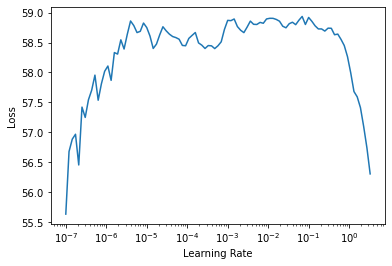

In [72]:
learn.lr_find()

In [73]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,31.328276,29.802715,4.962317,00:11
1,9.540549,23.316565,4.326280,00:11
2,4.066316,21.415688,4.076380,00:12
3,3.385599,19.718140,3.877175,00:12
4,2.838180,18.928007,3.773421,00:11
5,2.626594,18.123583,3.664977,00:11
6,2.587838,17.527607,3.583466,00:11
7,2.438620,17.157701,3.528949,00:12
8,2.273906,16.824812,3.483645,00:11
9,2.329935,16.600571,3.450710,00:12


In [74]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 4, metrics=flat_l1)

In [75]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,31.264219,29.781946,4.965319,00:10
1,15.217397,17.882677,3.610713,00:10
2,7.716425,15.405820,3.375469,00:10
3,4.245779,14.368069,3.249260,00:09
4,2.984031,13.708525,3.161744,00:09
5,2.178472,13.330661,3.103815,00:10
6,1.862037,13.001959,3.053869,00:10
7,1.658742,12.754318,3.009363,00:10
8,1.410770,12.613729,2.990992,00:09
9,1.344981,12.428010,2.953840,00:09


In [76]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 32, 'anime_uid': 32}, metrics=flat_l1)

In [77]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,4.525888,4.412737,1.631541,00:11
1,2.137032,4.327089,1.633142,00:11
2,0.982691,4.355665,1.604841,00:11
3,0.785398,4.355217,1.614985,00:11
4,0.631375,4.388999,1.610078,00:11
5,0.536511,4.379378,1.609915,00:11
6,0.520943,4.303681,1.604613,00:11
7,0.520909,4.414505,1.584491,00:11
8,0.478013,4.485714,1.590992,00:11
9,0.437864,4.392544,1.596414,00:11


In [79]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 64, 'anime_uid': 64}, layers = [1024, 512, 256], metrics=flat_l1)
# hacemos el modelo más profundo

In [80]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,4.775795,4.602237,1.620978,00:14
1,2.463941,4.405550,1.597584,00:14
2,1.305987,4.404706,1.603168,00:14
3,0.829148,4.346010,1.638951,00:14
4,0.703198,5.653776,2.019168,00:14
5,0.543923,85.170364,1.655019,00:14
6,0.488768,6.449002,2.110115,00:14
7,0.460834,4.416010,1.629224,00:14
8,0.441296,4.407097,1.598174,00:14
9,0.505898,4.648764,1.612675,00:14


In [81]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 4, use_nn = True, emb_szs = {'uid': 32, 'anime_uid': 32}, layers = [1024, 512], metrics=flat_l1)
# hacemos el modelo más profundo

In [82]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,4.670424,4.446086,1.649610,00:11
1,3.519014,4.353405,1.604801,00:12
2,1.460182,4.340763,1.679871,00:12
3,0.957452,4.269511,1.631672,00:12
4,0.721100,4.311582,1.608814,00:12
5,0.699525,4.250793,1.616281,00:12
6,0.583482,4.261444,1.613139,00:11
7,0.537673,4.407215,1.676090,00:12
8,0.491311,4.330667,1.597108,00:11
9,0.475981,4.365348,1.649837,00:12


evidentemente no mejoro mucho. Procedemos a añadir más columnas para ver si mejora el modelo.
En este caso vamos a añadir usuarios a los ratings pero para ello, tendremos que cargar nuevamente los datos
para añadir la columna profile.

In [85]:
users.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '9253', '34599', '3588', '13601', '6956']",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32281', '9989', '1943', '512']",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382', '849', '235', '35180', '31646']",https://myanimelist.net/profile/aManOfCulture99


In [91]:
ratings_again = pd.read_csv('/notebooks/storage/mydata/reviews.csv', low_memory = True)

In [92]:
ratings_again.head(1)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n \n \n \n \n more pics \n \n \n \n \n \n Overall \n 8 \n \n \n Story \n 8 \n \n \n Animation \n 8 \n \n \n Sound \n 10 \n \n \n Character \n 9 \n \n \n Enjoyment \n 8 \n \n \n \n\n \n First things firs...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8', 'Sound': '10', 'Character': '9', 'Enjoyment': '8'}",https://myanimelist.net/reviews.php?id=255938


In [93]:
ratings_again = ratings_again[["uid", "profile", "anime_uid", "score"]]

In [94]:
by_uid_ratings_again = ratings_again.sort_values('anime_uid')
by_uid_ratings_again.head()

,uid,profile,anime_uid,score
35257,273679,Hematospermia,1,10
36058,16217,tentacle_raep,1,10
35198,5740,RangFlash,1,10
35200,48839,reinis-jan,1,9
35205,296203,maxeraturee,1,10


Añadiremos primero los usuarios al ratings sin añadir los animes para ver si hay una mejora así

In [96]:
users.head(1)

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",https://myanimelist.net/profile/DesolatePsyche


In [97]:
currently_users = users[["profile", "gender", "birthday"]]

In [98]:
ratings_with_profile=by_uid_ratings_again.join(currently_users.set_index('profile'),on='profile')

In [100]:
ratings_with_profile.head()

,uid,profile,anime_uid,score,gender,birthday
35257,273679,Hematospermia,1,10,NaN,NaN
35257,273679,Hematospermia,1,10,NaN,NaN
36058,16217,tentacle_raep,1,10,Female,NaN
36058,16217,tentacle_raep,1,10,Female,NaN
36058,16217,tentacle_raep,1,10,Female,NaN


In [101]:
dls = fc.CollabDataLoaders.from_df(ratings_with_profile, user_name = 'uid', item_name = 'anime_uid', rating_name = 'score', bs=128)

In [102]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 32, 'anime_uid': 32}, metrics=flat_l1)

In [103]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,1.251788,1.248465,0.816297,00:29
1,0.640295,0.943825,0.658081,00:29
2,0.489135,0.776780,0.544172,00:29
3,0.512991,0.836055,0.566546,00:29
4,0.549725,0.849395,0.568839,00:30
5,0.582895,0.850243,0.570746,00:29
6,0.579169,0.861481,0.574403,00:30
7,0.593521,0.856575,0.572137,00:30
8,0.586353,0.885373,0.589337,00:29
9,0.573200,0.928905,0.591464,00:30


> Podemos observar que a bajado considerable únicamente añadiendo los usuarios, ahora añadiremos lo referente a anime

In [104]:
ratings_with_profile.head(1)

,uid,profile,anime_uid,score,gender,birthday
35257,273679,Hematospermia,1,10,NaN,NaN


In [106]:
by_uid_animes.head(1)

,uid_anime,popularity,ranked,'Comedy','Sports','Drama','School','Shounen','Music','Romance',...,'Kids','Shoujo Ai','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
764,1,39,26.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [108]:
ratings_with_profile.loc[(ratings_with_profile['anime_uid'] == 1)]

,uid,profile,anime_uid,score,gender,birthday
35257,273679,Hematospermia,1,10,NaN,NaN
35257,273679,Hematospermia,1,10,NaN,NaN
36058,16217,tentacle_raep,1,10,Female,NaN
36058,16217,tentacle_raep,1,10,Female,NaN
36058,16217,tentacle_raep,1,10,Female,NaN
...,...,...,...,...,...,...
161713,298643,WampaStompa,1,10,Male,"May 30, 1986"
161713,298643,WampaStompa,1,10,Male,"May 30, 1986"
161707,172685,Sasunaru4life,1,10,Female,"Sep 27, 1997"
161707,172685,Sasunaru4life,1,10,Female,"Sep 27, 1997"


In [109]:
new_ratings_with_profile = ratings_with_profile.join(by_uid_animes.set_index('uid_anime'), on='anime_uid')

In [110]:
new_ratings_with_profile.loc[(new_ratings_with_profile['anime_uid'] == 1)]

,uid,profile,anime_uid,score,gender,birthday,popularity,ranked,'Comedy','Sports',...,'Kids','Shoujo Ai','Martial Arts','Game','Thriller','Dementia','Harem','Hentai','Yaoi','Yuri'
35257,273679,Hematospermia,1,10,NaN,NaN,39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
35257,273679,Hematospermia,1,10,NaN,NaN,39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
36058,16217,tentacle_raep,1,10,Female,NaN,39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
36058,16217,tentacle_raep,1,10,Female,NaN,39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
36058,16217,tentacle_raep,1,10,Female,NaN,39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161713,298643,WampaStompa,1,10,Male,"May 30, 1986",39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
161713,298643,WampaStompa,1,10,Male,"May 30, 1986",39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
161707,172685,Sasunaru4life,1,10,Female,"Sep 27, 1997",39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False
161707,172685,Sasunaru4life,1,10,Female,"Sep 27, 1997",39,26.0,True,False,...,False,False,False,False,False,False,False,False,False,False


Podemos observar que se han añadido correctamente, procedemos ahora a evaluar el modelo con usuarios y anime

<a id="newmodel_all"><strong><h1>Un modelo que lo tiene todo</h1></strong></a>

In [111]:
dls = fc.CollabDataLoaders.from_df(new_ratings_with_profile, user_name = 'uid', item_name = 'anime_uid', rating_name = 'score', bs=128)

In [112]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 64, 'anime_uid': 64}, layers = [1024, 512, 256], metrics=flat_l1)
# hacemos el modelo más profundo

In [113]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,1.141843,1.012236,0.653933,00:59
1,0.671920,0.907944,0.495222,00:59
2,0.687530,63.673901,0.831003,00:59
3,0.739554,45.841385,0.694704,01:00
4,0.683679,264.949432,0.764557,00:59
5,0.786071,19.202662,0.631077,01:00
6,0.763677,21.682968,0.585929,00:59
7,0.782114,10.335063,0.600182,00:59
8,0.809013,49.138012,0.672021,00:59
9,0.733853,19.074610,0.600053,00:59


<a id="conc"><strong><h1>Conclusión</h1></strong></a>

Podemos observar que los últimos dos modelos fueron los mejores. 
- El modelo de raitings con usuarios 
- El modelo de raitings con usuarios y animes 
